In [ ]:
#2.1
import pandas as pd
!pip -q install gdown

!gdown --fuzzy "https://drive.google.com/file/d/1mWHneibejp026KCQbHmgly16L9wAuq8Q/view?usp=drive_link" -O Mall_Customers.csv

data = pd.read_csv("Mall_Customers.csv")

data_info = data.info()
data_info
data = data.copy()

data = data.drop_duplicates()
data = data.dropna()
print("Shape after cleaning:", data.shape)
data.head()

numeric_cols = data.select_dtypes(include=["number"]).columns.tolist()
print("Numeric columns:", numeric_cols)

if "CustomerID" in numeric_cols:
    numeric_cols.remove("CustomerID")

X = data[numeric_cols].copy()
print("Selected numeric features for scaling/model:", X.columns.tolist())
X.head()

from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=data.index)

print("Scaled means (approx 0):")
print(X_scaled_df.mean().round(4))
print("\nScaled stds (approx 1):")
print(X_scaled_df.std(ddof=0).round(4))

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=23)
X_pca2 = pca.fit_transform(X_scaled_df)

pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=data.index)

print("Explained variance ratio:", pca.explained_variance_ratio_)
pca_df.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

if "Gender" in data.columns:
    genders = data["Gender"].astype(str)
    colors = genders.map({"Male": 0, "Female": 1}).fillna(2)

    plt.scatter(pca_df["PC1"], pca_df["PC2"], c=colors, alpha=0.8)
    plt.title("PCA (2D) Visualization - colored by Gender (optional)")
else:
    plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.8)
    plt.title("PCA (2D) Visualization")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()



Downloading...
From: https://drive.google.com/uc?id=1mWHneibejp026KCQbHmgly16L9wAuq8Q
To: /content/Mall_Customers.csv
100% 3.98k/3.98k [00:00<00:00, 13.3MB/s]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
Shape after cleaning: (200, 5)
Numeric columns: ['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Selected numeric features for scaling/model: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Scaled means (approx 0):
Age                      -0.0
Annual Income (k$)       -0.0
Spending Score (1-1

    K     Inertia  Silhouette
0   2  389.386189    0.335472
1   3  295.501955    0.358958
2   4  205.225147    0.403958
3   5  168.247580    0.416643
4   6  133.868334    0.427428
5   7  117.231929    0.419607
6   8  103.876008    0.407537
7   9   92.432574    0.418168
8  10   82.456952    0.401493


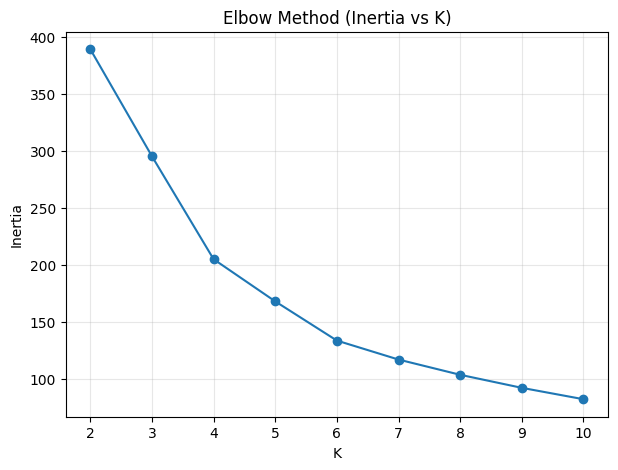

In [ ]:
#2.2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

Ks = range(2, 11)

inertias = []
sil_scores = []

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=23, n_init=10)
    labels = kmeans.fit_predict(X_scaled_df)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled_df, labels))

results = pd.DataFrame({
    "K": list(Ks),
    "Inertia": inertias,
    "Silhouette": sil_scores
})

print(results)

plt.figure(figsize=(7,5))
plt.plot(results["K"], results["Inertia"], marker="o")
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(results["K"], results["Silhouette"], marker="o")
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
#1.3
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pandas as pd

K_final = 6

linkages = ["single", "complete", "average", "ward"]
rows = []

for link in linkages:
    try:
        model = AgglomerativeClustering(n_clusters=K_final, linkage=link, metric="euclidean")
    except TypeError:
        model = AgglomerativeClustering(n_clusters=K_final, linkage=link, affinity="euclidean")

    labels = model.fit_predict(X_scaled_df)
    sil = silhouette_score(X_scaled_df, labels)

    rows.append({"linkage": link, "K": K_final, "silhouette": sil})

results_hc = pd.DataFrame(rows).sort_values("silhouette", ascending=False).reset_index(drop=True)
print(results_hc)

best = results_hc.iloc[0]
print(f"Best linkage: {best['linkage']}  |  silhouette: {best['silhouette']:.4f}  |  K={int(best['K'])}")



    linkage  K  silhouette
0      ward  6    0.420117
1   average  6    0.389573
2  complete  6    0.374561
3    single  6   -0.042750
Best linkage: ward  |  silhouette: 0.4201  |  K=6


In [ ]:
#1.4
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_list = [0.2, 0.4, 0.6, 0.8, 1.0]
min_samples_list = [3, 5, 10]

rows = []

for eps in eps_list:
    for ms in min_samples_list:
        db = DBSCAN(eps=eps, min_samples=ms, metric="euclidean")
        labels = db.fit_predict(X_scaled_df)

        n_total = len(labels)
        noise_mask = (labels == -1)
        n_noise = noise_mask.sum()
        noise_ratio = n_noise / n_total

        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        non_noise_mask = ~noise_mask
        labels_non_noise = labels[non_noise_mask]
        X_non_noise = X_scaled_df.loc[non_noise_mask]

        sil = np.nan
        if n_clusters >= 2 and len(X_non_noise) > 1:
            sil = silhouette_score(X_non_noise, labels_non_noise)

        rows.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_ratio": noise_ratio,
            "silhouette_non_noise": sil,
            "n_noise": int(n_noise),
            "n_non_noise": int(n_total - n_noise)
        })

results_dbscan = pd.DataFrame(rows)

results_dbscan_sorted = results_dbscan.sort_values(
    by=["silhouette_non_noise", "noise_ratio", "n_clusters"],
    ascending=[False, True, True],
    na_position="last"
).reset_index(drop=True)

display(results_dbscan_sorted)



eps  min_samples  n_clusters  noise_ratio  silhouette_non_noise  n_noise  \
0   0.4           10           2        0.850              0.766073      170   
1   0.2            3          11        0.805              0.645880      161   
2   0.6           10           4        0.330              0.529589       66   
3   0.4            5           6        0.490              0.519023       98   
4   0.4            3          10        0.295              0.442575       59   
5   0.6            5           2        0.140              0.273047       28   
6   0.6            3           3        0.070              0.214881       14   
7   1.0            3           1        0.005                   NaN        1   
8   1.0            5           1        0.010                   NaN        2   
9   0.8            3           1        0.015                   NaN        3   
10  1.0           10           1        0.025                   NaN        5   
11  0.8            5           1        0.030                   NaN        6   
12  0.8           10           1        0.115                   NaN       23   
13  0.2            5           1        0.975                   NaN      195   
14  0.2           10           0        1.000                   NaN      200   

    n_non_noise  
0            30  
1            39  
2           134  
3           102  
4           141  
5           172  
6           186  
7           199  
8           198  
9           197  
10          195  
11          194  
12          177  
13            5  
14            0

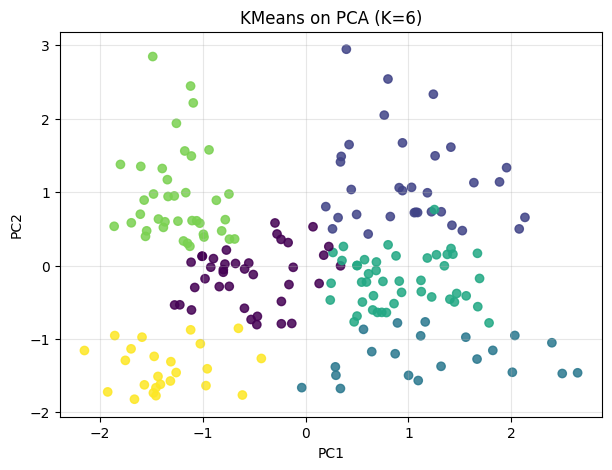

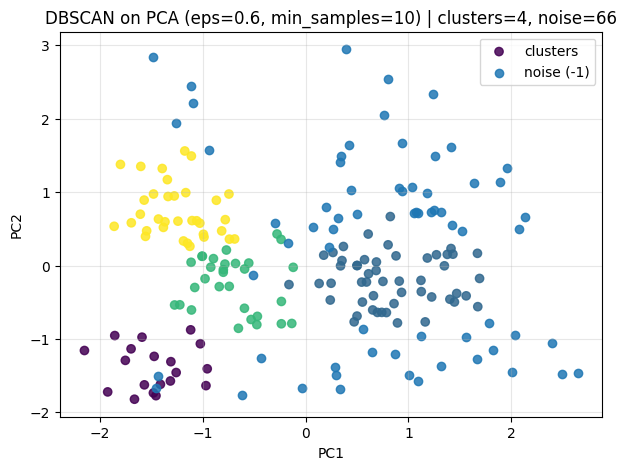

kmeans  agglomerative  dbscan
0       5              4      -1
1       5              5       0
2       2              4      -1
3       5              5       0
4       2              4      -1

In [ ]:
#1.5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

K_final = 6
best_linkage = "ward"
best_eps = 0.6
best_min_samples = 10

kmeans = KMeans(n_clusters=K_final, random_state=23, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled_df)

plt.figure(figsize=(7,5))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=labels_kmeans, alpha=0.85)
plt.title(f"KMeans on PCA (K={K_final})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()

try:
    agg = AgglomerativeClustering(n_clusters=K_final, linkage=best_linkage, metric="euclidean")
except TypeError:
    agg = AgglomerativeClustering(n_clusters=K_final, linkage=best_linkage, affinity="euclidean")

labels_agg = agg.fit_predict(X_scaled_df)

plt.figure(figsize=(7,5))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=labels_agg, alpha=0.85)
plt.title(f"Agglomerative on PCA (linkage={best_linkage}, K={K_final})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()

db = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric="euclidean")
labels_db = db.fit_predict(X_scaled_df)

noise_mask = (labels_db == -1)
n_noise = noise_mask.sum()
n_clusters_db = len(set(labels_db)) - (1 if -1 in set(labels_db) else 0)

plt.figure(figsize=(7,5))

plt.scatter(pca_df.loc[~noise_mask, "PC1"], pca_df.loc[~noise_mask, "PC2"],
            c=labels_db[~noise_mask], alpha=0.85, label="clusters")

plt.scatter(pca_df.loc[noise_mask, "PC1"], pca_df.loc[noise_mask, "PC2"],
            alpha=0.85, label="noise (-1)")

plt.title(f"DBSCAN on PCA (eps={best_eps}, min_samples={best_min_samples}) | "
          f"clusters={n_clusters_db}, noise={n_noise}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

labels_df = pd.DataFrame({
    "kmeans": labels_kmeans,
    "agglomerative": labels_agg,
    "dbscan": labels_db
}, index=X_scaled_df.index)

labels_df.head()
